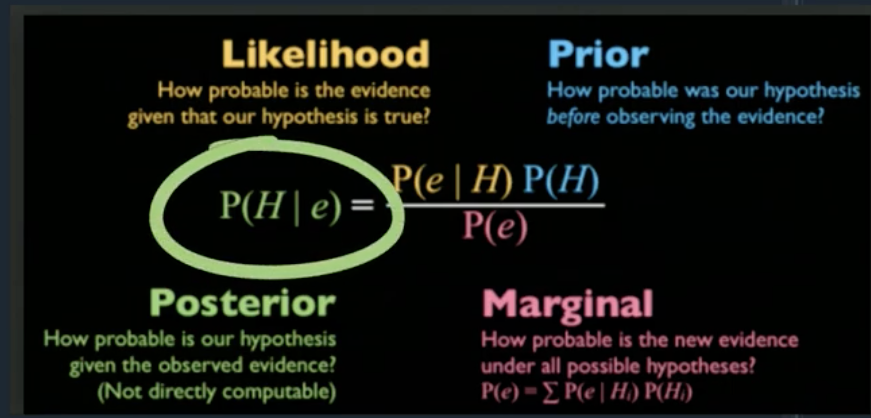

In [2]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from devai.eda import plot_confusion_matrix

In [3]:
data = pd.read_csv("../data/imdb.csv")
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
X = data["review"]
y = data["sentiment"]

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
vec = CountVectorizer(max_features=17000)
X_train = vec.fit_transform(X_train)
X_test = vec.transform(X_test)
X_train = X_train.toarray()
X_test = X_test.toarray()

In [22]:
enc = LabelEncoder()
y_train = enc.fit_transform(y_train)
y_test = enc.transform(y_test)

# naive bayes

In [24]:
class NaiveBayes:
    def __init__(self, binary=False):
        self.binary = binary
    @staticmethod
    def binarize(x):
        return (x>0).astype(int)
    def fit(self,x,y):
        if self.binary: x = self.binarize(x)
        self.num_classes = len(np.unique(y))
        self.num_feats = x.shape[1]
        self.likelihoods = np.zeros((self.num_feats,self.num_classes))
        self.priors = np.zeros((self.num_classes))
        for c in range(self.num_classes):
            xc = x[y==c]
            # we take the logs because it is easier to compute and do matrix mul during inference
            self.likelihoods[:,c] = np.log(xc.mean(0))
            self.priors[c] = np.log(xc.shape[0]/x.shape[0])
    
    def predict(self, x):
        """
        x shape: num_exampels, num_feats
        """ 
        if self.binary: x = self.binarize(x)
        res = np.dot(x,self.likelihoods) + self.priors[None,:]
        return np.argmax(res, 1)

In [25]:
nb = NaiveBayes(binary=False)
nb.fit(X_train,y_train)

<ipython-input-24-5e6c44db28d8>:16: RuntimeWarning: divide by zero encountered in log
  self.likelihoods[:,c] = np.log(xc.mean(0))


In [26]:
preds = nb.predict(X_test)

In [28]:
# train, test accuracy 
(nb.predict(X_train)==y_train).mean(),(preds==y_test).mean()

(0.5012537313432835, 0.4974545454545454)

In [ ]:
print(classification_report(nb.predict(X_test), y_test))

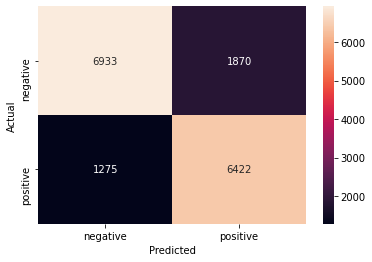

In [10]:
plot_confusion_matrix(cm=confusion_matrix(nb.predict(X_test),y_test), labels=enc.classes_)

In [29]:
class NaiveBayesGDF:
    """
    https://www.youtube.com/watch?v=3trW5Lig7BU
    https://github.com/aladdinpersson/Machine-Learning-Collection/blob/235beb22c13ac2aac76d8c8e9ae79ba7ade1fc4b/ML/algorithms/naivebayes/naivebayes.py
    """
    def __init__(self):
        pass

    def fit(self, X, y):
        self.classes_mean = {}
        self.classes_variance = {}
        self.classes_prior = {}
        num_examples, self.num_features = X.shape
        self.num_classes = len(np.unique(y))
        self.eps = 1e-6

        for c in range(self.num_classes):
            X_c = X[y == c]

            self.classes_mean[str(c)] = np.mean(X_c, axis=0)
            self.classes_variance[str(c)] = np.var(X_c, axis=0)
            self.classes_prior[str(c)] = X_c.shape[0] / X.shape[0]

    def predict(self, X):
        probs = np.zeros((X.shape[0], self.num_classes))

        for c in range(self.num_classes):
            prior = self.classes_prior[str(c)]
            probs_c = self.density_function(
                X, self.classes_mean[str(c)], self.classes_variance[str(c)]
            )
            probs[:, c] = probs_c + np.log(prior)

        return np.argmax(probs, 1)

    def density_function(self, x, mean, sigma):
        # Calculate probability from Gaussian density function
        const = -self.num_features / 2 * np.log(2 * np.pi) - 0.5 * np.sum(
            np.log(sigma + self.eps)
        )
        probs = 0.5 * np.sum(np.power(x - mean, 2) / (sigma + self.eps), 1)
        return const - probs

In [30]:
nb_gdf = NaiveBayesGDF()
nb_gdf.fit(X_train, y_train)

In [31]:
# train, test accuracy 
(nb_gdf.predict(X_train)==y_train).mean(),(nb_gdf.predict(X_test)==y_test).mean()

(0.769223880597015, 0.7064848484848485)

In [32]:
print(classification_report(nb_gdf.predict(X_test), y_test))

              precision    recall  f1-score   support

           0       0.85      0.66      0.74     10669
           1       0.56      0.80      0.66      5831

    accuracy                           0.71     16500
   macro avg       0.71      0.73      0.70     16500
weighted avg       0.75      0.71      0.71     16500



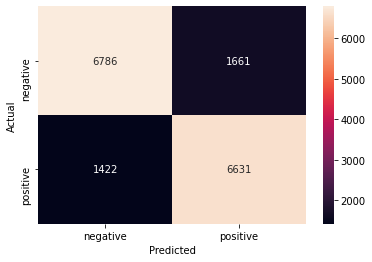

In [15]:
plot_confusion_matrix(cm=confusion_matrix(nb_gdf.predict(X_test),y_test), labels=enc.classes_)